<a href="https://colab.research.google.com/github/jsebastianquiroga/analitica_ia_puj/blob/main/DL/01_deep_learning_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de Red Neuronal

En este laboratorio se va a entrenar una red neuronal sencilla para la clasificación de imágenes de Ropa en sus respectivas categorías. 

## Objetivos de Aprendizaje

- Familiarizarse con TensorFlow para el entrenamiento de Redes Neuronales
- Recordar los conceptos de Redes Neuronales, Funciones de Costo y Métricas de Evaluación


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
import numpy as np


# 1. Descarga de Información 

La información del Fashion MNIST se encuentra como uno de los DataSets disponibles dentro de TensorFlow. Es posible llamarlo utilizando [`tf.keras.datasets.fashion_mnist`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist). Se puede consultar el resto de conjuntos de datos disponibles en [la documentación de TensorFLow](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

A continuación, cargue la información de Fashion MNIST. 

In [31]:
# Carga de FashionMNIST

###
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
###

El conjunto de datos secompone de 10 clases de ropa para predecir. En la siguiente celda se pueden ver algunos ejemplos de cada categoría.

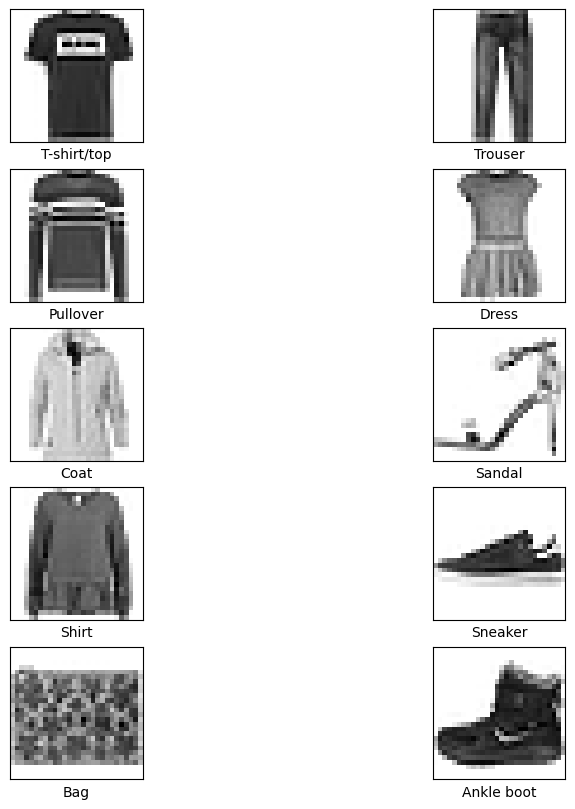

In [32]:
category_indices = [np.where(y_train == i)[0][0] for i in range(10)]
category_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Plot examples
plt.figure(figsize=(10, 10))
for i, index in enumerate(category_indices):
    plt.subplot(5, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[index], cmap=plt.cm.binary)
    plt.xlabel(str(y_train[index]))


    plt.xlabel(category_labels[y_train[index]])
plt.show()

Puede observarse que cada "dato" es una imagen de dimensión 28x28, y que contiene valores de 0 al 255. Donde 0 es un pixel negro, y 255 es un pixel blanco. 

In [33]:
x_train.shape

(60000, 28, 28)

In [34]:
x_train[0, :, :].min()

0

In [35]:
x_train[0, :, :].max()

255

A continuación procedemos a reescalar los datos, de forma que la intensidad del pixel esté en el intervalo [0, 1]. 

In [36]:
# Normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0


La función a continuación nos va a permitir observar las predicciones de un modelo y determinar qué tanto se equivocó o no.

In [37]:
def show_random_examples(model, x, y, num_examples=10):
    """
    Selección aleatoria de ejemplos y predicciones.

    Params:
    ---------
      model (tf.keras.Model):
        Modelo de Red Neuronal para predicciones

      x (numpy.array):
        Numpy Array con pixeles de la ropa

      y (numpy.array):
        Numpy Array indicando categoría

    """
    # Muestra Aleatorio de índices
    indices = np.random.choice(range(x.shape[0]), num_examples)

    # Obtención de Imágenes y Categorías de Verdad
    images = x[indices]
    true_labels = y[indices]

    # Generar Predicciones del Modelo
    predictions = model.predict(images) # El modelo predice probabilidades
    predicted_labels = np.argmax(predictions, axis=-1) # Se requiere obtener la categoría que maximice esas probabilidad
    predicted_probs = np.max(predictions, axis=-1) # Selección de Probabilidad de categoría ganadora

    # Display the images, true labels, and predicted labels
    plt.figure(figsize=(10, 5))
    for i, (img, true_label, pred_label, prob) in enumerate(zip(images, true_labels, predicted_labels, predicted_probs)):
        plt.subplot(2, num_examples // 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        title_color = 'red' if true_label != pred_label else 'black'
        plt.title(f"True: {category_labels[true_label]}\nPredicted: {category_labels[pred_label]} ({prob:.2f})", fontsize=10, color=title_color)
    plt.tight_layout()
    plt.show()

# Call the function to display random examples and their classifications


# 2. Definición del Modelo

A continuación tendrá que definir un modelo de red neuronal como usted considere. Para esto, tiene a su disposición las capas Densas (fully connected layers) que se encuentran en [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Siéntase libre de explorar con la cantidad de capas ocultas, la cantidad de neuronas, las funciones de activación, etc... 

**Nota:** Recuerde que existen 10 categorías de predicción, por lo que debe escoger adecuadamente el número de neuronas de la capa final y la función de activación de la misma. Puede ver las funciones de activación disponibles en [la documentación de TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 

In [38]:
### Defina el modelo inicial

model = Sequential([
    Flatten(input_shape=(28, 28)), # No borrar esta
    Dense(196, activation= 'leaky_relu'),
    Dense(98, activation='tanh'),
    Dense(196, activation = 'relu'),
    Dense(10, activation = 'Softmax')
])

###

La red neuronal se inicializó con unos pesos aleatorios. Este es un modelo que prácticamente está adivinando. A continuación, utilice la función `show_random_examples` para determinar qué tan capaz es el modelo antes de comenzar a aprender.

1/1 [==============================] - 0s 83ms/step


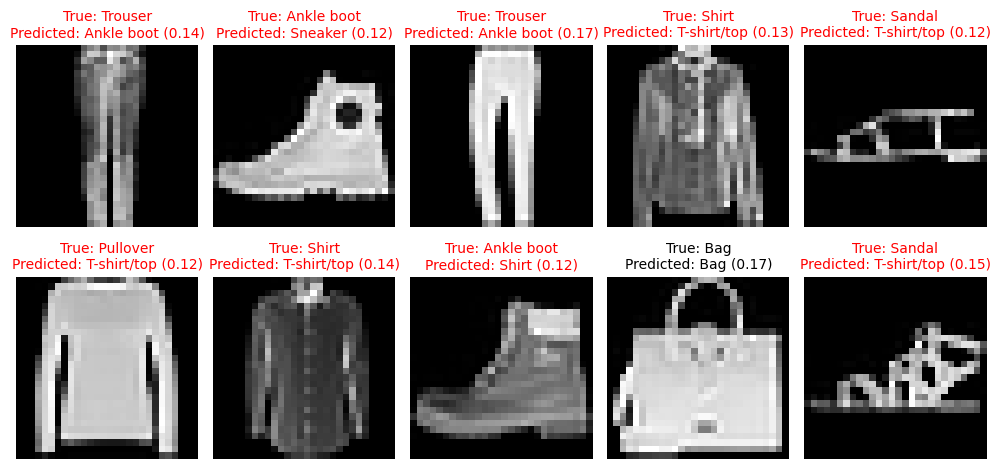

In [39]:
### Utilice la función show_random_examples para mostrar las predicciones en algunos ejemplos en Test
show_random_examples(model, x_test, y_test)
###

Para entrenar el modelo, es necesario definir cuál es el objetivo y cómo se desea hacer. Es por esto que se requiere *compilar* el modelo utilizando el método [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) del API de Tensorflow. 

En este debe definir qué optimizador utilizar, cuál es la función a minimizar y qué métricas de seguimiento se van a evaluar. 

**Nota:** Debido al formato de los datos, se utilizará la función de pérdida [`SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) e igualmente la [`SparseCategoricalAccuracy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy). 

**Nota 2:** Se recomienda utilizar [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) como el optimizador, pero se recomienda probar los otros optimizadores disponibles en [la documentación de TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). 

In [45]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
### Compile el modelo utilizando Sparce Categorical Crossentropy y Accuracy
model.compile(
    optimizer=Adam(learning_rate=0.001), ## Pruebe otros Optimizadores
    loss= SparseCategoricalCrossentropy(), 
    metrics= [SparseCategoricalAccuracy()]
)

###


# 3. Entrenamiento de Modelo

Una vez definida la estructura del modelo y el objetivo de entrenamiento, se puede proceder a entrenar. Se utilizará el método `fit` del modelo. Pruebe probar otros batchsizes. 

In [46]:
model_history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.4939 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.4033 - val_sparse_categorical_accuracy: 0.8505
Epoch 2/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.8613 - val_loss: 0.3948 - val_sparse_categorical_accuracy: 0.8570
Epoch 3/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.3473 - val_sparse_categorical_accuracy: 0.8728
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.8821 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.8817
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3007 - sparse_categorical_accuracy: 0.8873 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.8748
Epoch 6/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2853 -

Una vez entrenado el modelo, se procede a revisar sus predicciones en la base de datos de tes. 

1/1 [==============================] - 0s 25ms/step


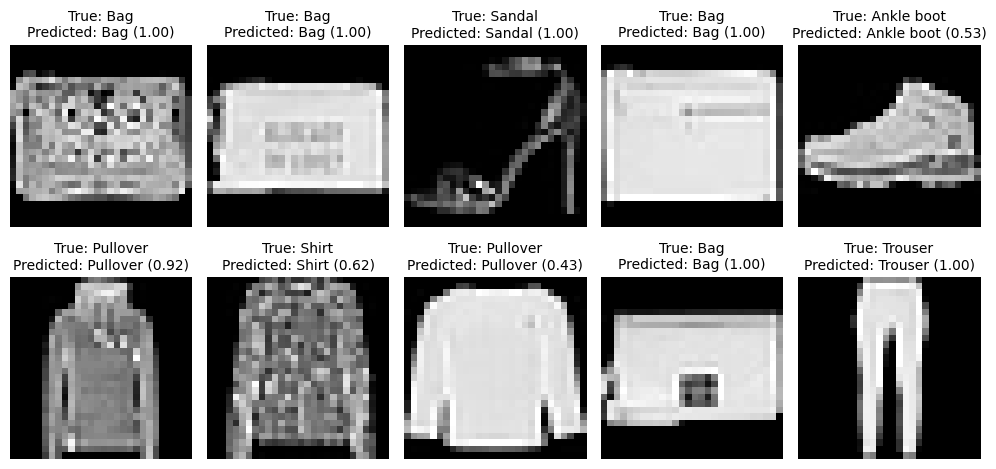

In [49]:
show_random_examples(model, x_test, y_test)

A continuación, utilice el método [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) para determinar el desempeño del modelo en Test. 

In [50]:
###
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

###


313/313 [==============================] - 2s 4ms/step - loss: 0.3514 - sparse_categorical_accuracy: 0.8730
Test accuracy: 0.8730000257492065


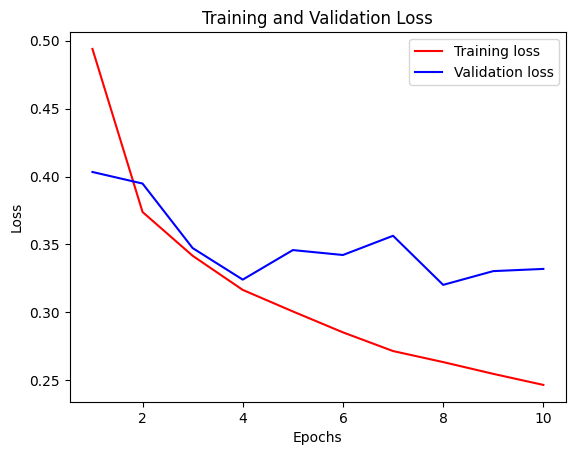

In [51]:
def plot_training_and_validation_loss(model_history):
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Call the function to plot the training and validation loss
plot_training_and_validation_loss(model_history)


# (Opcional) Early Stopping

Una de las técnicas más importantes para evitar que un modelo haga overfitting, es utilizar el Early Stopping. Este método consiste en monitorear la pérdida del modelo en validación y detener el entrenamiento si esta métrica deja de mejorar consecutivamente. 

A continuación utilizará el Callback de EarlyStopping [`tf.keras.callbacks.EarlyStopping`]() para entrenar la red lo más posible evitando hacer overfitting.

Para esto volveremos a crear un modelo nuevo, que no haya aprendido nada aún. Utilizaremos el código del modelo que se definió anteriormente. 

In [59]:
### Copie el código de su modelo inicial 

model_early = Sequential([
    Flatten(input_shape=(28, 28)), # No borrar esta
    Dense(196, activation= 'leaky_relu'),
    Dense(98, activation='tanh'),
    Dense(49, activation = 'relu'),
    Dense(10, activation = 'Softmax')
])

###

### No olvide compilarlo
model_early.compile(
    optimizer=Adam(learning_rate=0.001), ## Pruebe otros Optimizadores
    loss= SparseCategoricalCrossentropy(), 
    metrics= [SparseCategoricalAccuracy()]
)

###


In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [61]:
model_early_history = model_early.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.4993 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.8399
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3771 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.3585 - val_sparse_categorical_accuracy: 0.8687
Epoch 3/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.3590 - val_sparse_categorical_accuracy: 0.8688
Epoch 4/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3200 - sparse_categorical_accuracy: 0.8809 - val_loss: 0.3397 - val_sparse_categorical_accuracy: 0.8775
Epoch 5/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3010 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.8771
Epoch 6/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.28

1/1 [==============================] - 0s 105ms/step


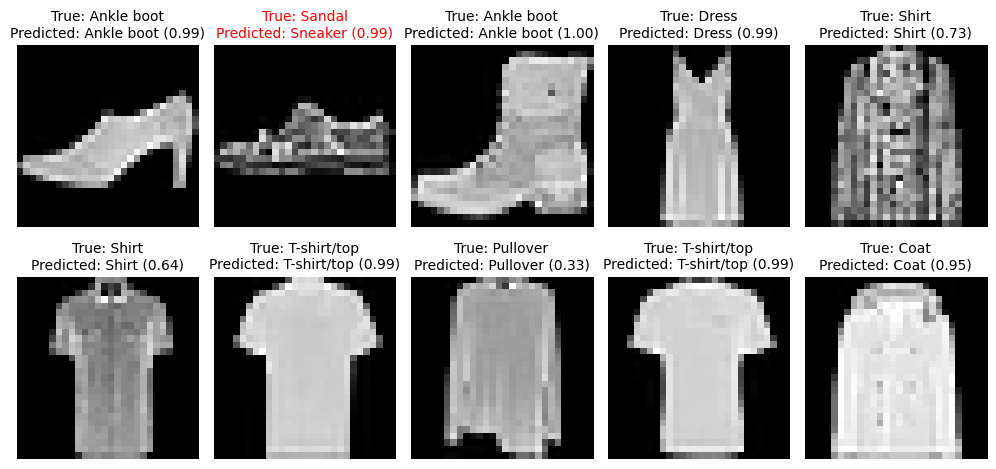

In [62]:
show_random_examples(model_early, x_test, y_test)

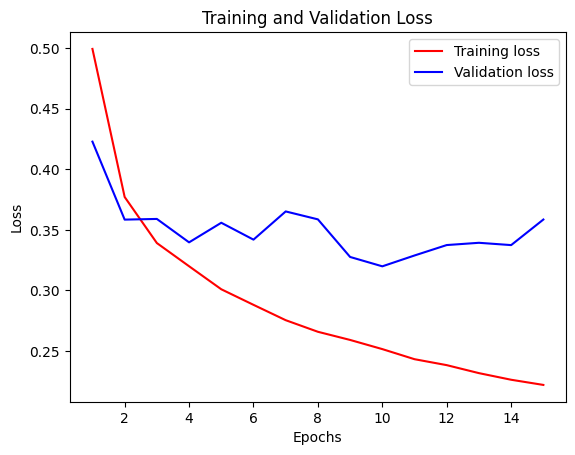

In [63]:
plot_training_and_validation_loss(model_early_history)

In [64]:
###
test_loss, test_accuracy = model_early.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

###


313/313 [==============================] - 1s 3ms/step - loss: 0.3407 - sparse_categorical_accuracy: 0.8793
Test accuracy: 0.8792999982833862
